In [5]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

# Creating the db 

two separates db for senate and congress

In [6]:
CLIP_TRESHOLD = 40
clipping_stats_list = []

# Loop through congress files
for i in range(79, 112):
    
    "------ Loading files -------"
    
    year_str = f"{i:03}"
    base_dir_load = Path("../data/raw")

    speeches_file = base_dir_load / f"speeches/speeches_{year_str}.txt"
    map_file = base_dir_load / f"speaker_map/{year_str}_SpeakerMap.txt"
    metadata_file = base_dir_load /f"metadata/descr_{year_str}.txt"
    
    print("Processing:", speeches_file, map_file, metadata_file)
    df_speeches = pd.read_csv(speeches_file, sep="|", encoding="latin1", dtype={"speech_id": str}, on_bad_lines="skip", engine="python")
    df_map = pd.read_csv(map_file, encoding='windows-1252', delimiter="|")
    df_metadata = pd.read_csv(metadata_file, encoding='windows-1252', delimiter="|")

    # converts type
    df_speeches["speech_id"] = pd.to_numeric(df_speeches["speech_id"], errors="coerce").astype("Int64")
    df_map.chamber = pd.Categorical(df_map.chamber)
    df_map.party = pd.Categorical(df_map.party)
    
    "------ Dropping column -------"
    
    # Clean speaker map
    df_map = df_map.drop(["district", "nonvoting", "state", "gender"], axis=1)
    #drop also lastname firstname and char_count
    # Clean metadata
    df_metadata = df_metadata[['speech_id', 'date', 'char_count', 'word_count']]

    "------ Merging -------"
    
    df_merge1 = pd.merge(df_speeches, df_map, on="speech_id", how="outer")
    df_merged = pd.merge(df_merge1, df_metadata, on="speech_id", how="outer")
    
    #checking speaker_id when is na
    """ rows_with_speakerid_na = df_merged[df_merged['speakerid'].isna()]
    rows_with_party_na = df_merged[df_merged['party'].isna()]
    print(rows_with_speakerid_na.head())
    print(rows_with_speakerid_na.shape) """

    df_merged = df_merged.dropna(subset=["speakerid"])
    df_merged['speakerid'] = df_merged['speakerid'].astype(int)
    df_merged = df_merged[df_merged['party'].isin(['D', 'R'])]
    df_merged['party'] = df_merged['party'].cat.remove_unused_categories()
    
    #clipping speeches
    count_after_basic_cleaning = len(df_merged)
    
    # --- Check and remove NA in 'speech' column ---
    count_before_speech_na_drop = len(df_merged)
    df_merged = df_merged.dropna(subset=['speech'])
    count_after_speech_na_drop = len(df_merged)
    speech_na_removed = count_before_speech_na_drop - count_after_speech_na_drop
    
    # --- Check and remove duplicate 'speech' entries ---
    count_before_duplicate_drop = len(df_merged)
    df_merged = df_merged.drop_duplicates(subset=['speech'])
    count_after_duplicate_drop = len(df_merged)
    duplicates_removed = count_before_duplicate_drop - count_after_duplicate_drop

    # --- Clipping speeches based on word_count ---
    count_before_clip = len(df_merged)
    df_merged = df_merged[df_merged['word_count'] > CLIP_TRESHOLD]
    count_after_clip = len(df_merged)
    clipped_removed = count_before_clip - count_after_clip
    
    # Update the dictionary keys to reflect the new steps
    clipping_stats_list.append({
        'Congress': i,
        'Start Count (After Basic Clean)': count_after_basic_cleaning,
        'Removed (Speech NA)': speech_na_removed,
        'Removed (Duplicates)': duplicates_removed,
        'Removed (Clipped)': clipped_removed,
        'Final Count (After Clipping)': count_after_clip
    })
    
    #rename date to year
    df_merged['date'] = df_merged['date'].astype(str).str[:4].astype(int)
    df_merged.rename(columns={'date': 'year'}, inplace=True)
    
    # Save chamber-specific dataframes
    df_senate = df_merged[df_merged['chamber'] == 'S'].copy()
    df_house = df_merged[df_merged['chamber'] == 'H'].copy()
    
    #print(df_house.head())

    "------ Saving to csv -------"
    # Define relative base directory
    base_dir_merged = Path("../data/merged")
    base_dir_senate = Path("../data/merged/senate_db")
    base_dir_house = Path("../data/merged/house_db")

    # Construct full file paths
    filepath_senate = base_dir_senate / f"senate_merged_{year_str}.csv"
    filepath_house = base_dir_house / f"house_merged_{year_str}.csv"

    # Create the folder if it doesn't exist
    base_dir_senate.mkdir(parents=True, exist_ok=True)
    base_dir_house.mkdir(parents=True, exist_ok=True)

    # Save to CSV
    df_senate.to_csv(filepath_senate, index=False)
    df_house.to_csv(filepath_house, index=False)
    with open('clipping_stats.json', 'w') as f:
        json.dump(clipping_stats_list, f, indent=4)


Processing: ..\data\raw\speeches\speeches_079.txt ..\data\raw\speaker_map\079_SpeakerMap.txt ..\data\raw\metadata\descr_079.txt
Processing: ..\data\raw\speeches\speeches_080.txt ..\data\raw\speaker_map\080_SpeakerMap.txt ..\data\raw\metadata\descr_080.txt
Processing: ..\data\raw\speeches\speeches_081.txt ..\data\raw\speaker_map\081_SpeakerMap.txt ..\data\raw\metadata\descr_081.txt
Processing: ..\data\raw\speeches\speeches_082.txt ..\data\raw\speaker_map\082_SpeakerMap.txt ..\data\raw\metadata\descr_082.txt
Processing: ..\data\raw\speeches\speeches_083.txt ..\data\raw\speaker_map\083_SpeakerMap.txt ..\data\raw\metadata\descr_083.txt
Processing: ..\data\raw\speeches\speeches_084.txt ..\data\raw\speaker_map\084_SpeakerMap.txt ..\data\raw\metadata\descr_084.txt
Processing: ..\data\raw\speeches\speeches_085.txt ..\data\raw\speaker_map\085_SpeakerMap.txt ..\data\raw\metadata\descr_085.txt
Processing: ..\data\raw\speeches\speeches_086.txt ..\data\raw\speaker_map\086_SpeakerMap.txt ..\data\raw

Working on clip

In [ ]:
year_str = f"{79:03}"
base_dir = Path("../data/merged")
house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
df = pd.read_csv(house_file)

word_count_threshold = 40 # Example: speeches with fewer than 100 words
number_of_samples = 50     # Example: how many speeches to sample
# --- Filter the DataFrame based on the word count threshold ---
df_short_speeches = df[df['word_count'] < word_count_threshold]
df_short_speeches = df_short_speeches[['speech_id', 'speech','word_count']]

sampled_speeches = df_short_speeches.sample(n=number_of_samples) # Using a random_state for reproducibility

# --- Adjust pandas display options to show full column width ---
# Store current options to restore them later (good practice)
original_max_colwidth = pd.get_option('display.max_colwidth')
original_max_columns = pd.get_option('display.max_columns') # Also good to show all columns

# Set new options
# Set max_colwidth to None to show *all* text in the column.
# Be cautious: if speeches are extremely long, this can produce massive output.
# Alternatively, set it to a large integer (e.g., 5000) to see a significant portion.
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) # Ensure all columns are shown, not just first/last

# --- Now print the sampled DataFrame (it will use the new display options) ---
print("\n--- Sampled Speeches with Full Speech Text Displayed ---")
print(sampled_speeches)

# --- IMPORTANT: Restore original pandas display options ---
pd.set_option('display.max_colwidth', original_max_colwidth)
pd.set_option('display.max_columns', original_max_columns)

print("\n--- Pandas display options restored ---")




--- Clipping Statistics Summary ---
    Congress  Start Count (After Basic Clean)  Removed (Speech NA)  \
0         79                           209920                 1171   
1         80                           167446                  793   
2         81                           278915                  629   
3         82                           214505                  483   
4         83                           210605                  625   
5         84                           167026                  468   
6         85                           218268                  271   
7         86                           224178                  116   
8         87                           225267                  144   
9         88                           227549                  390   
10        89                           227787                  267   
11        90                           249093                  121   
12        91                           249350        

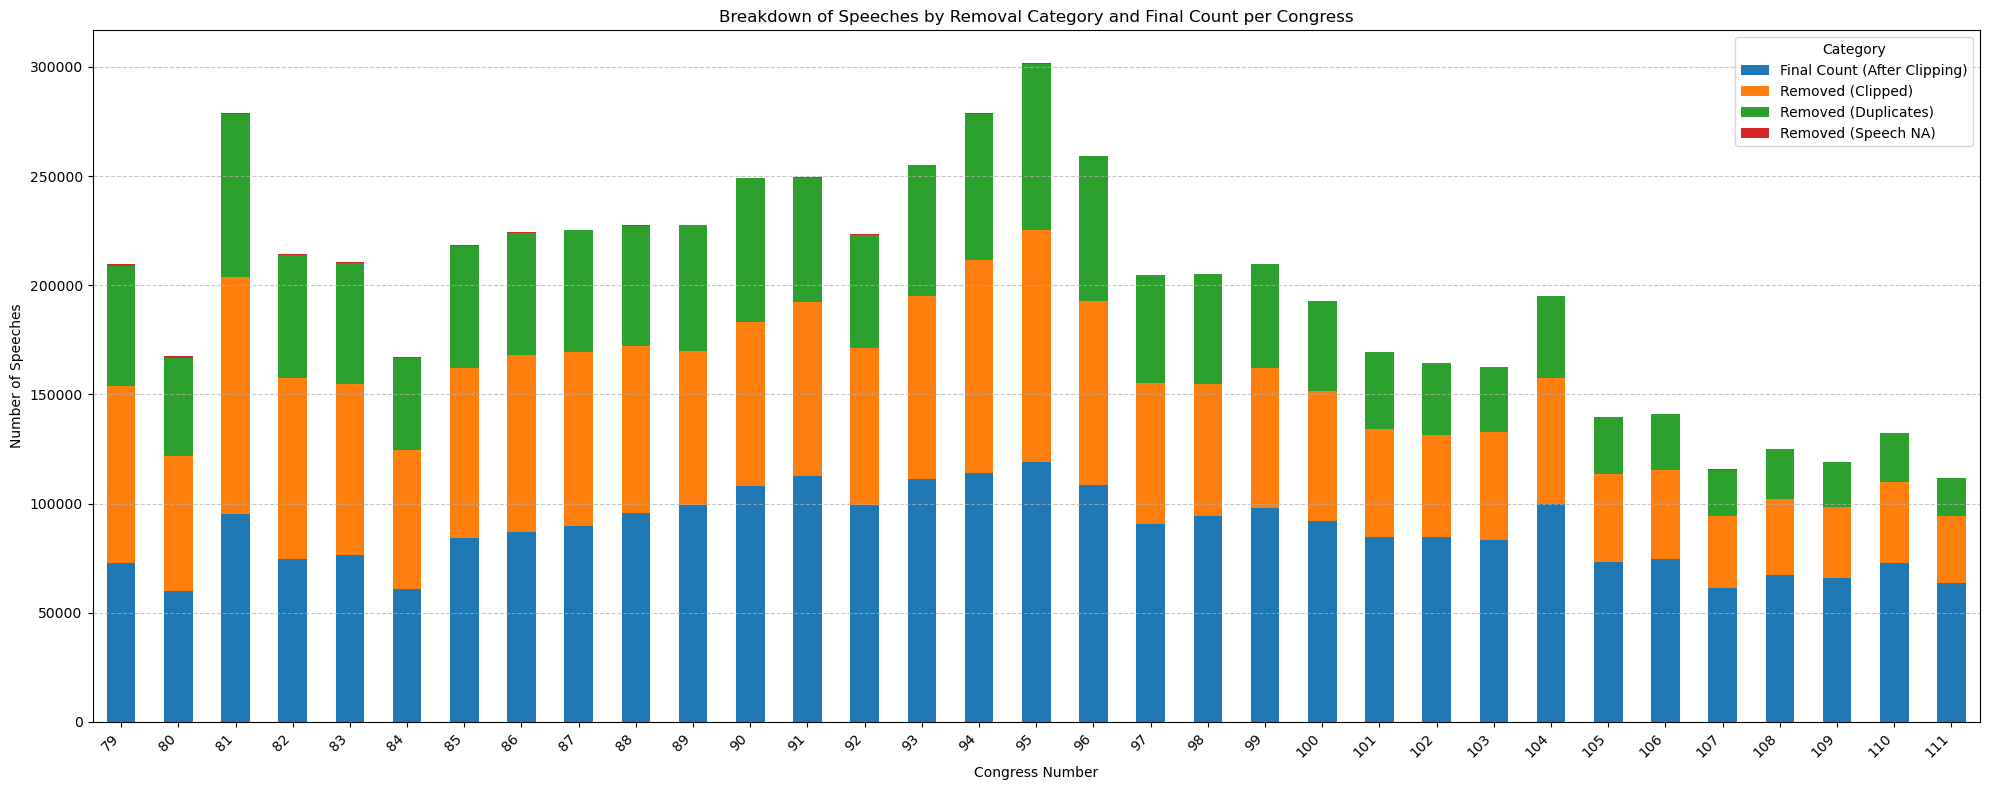

Generating Line Plot (Percentages)...


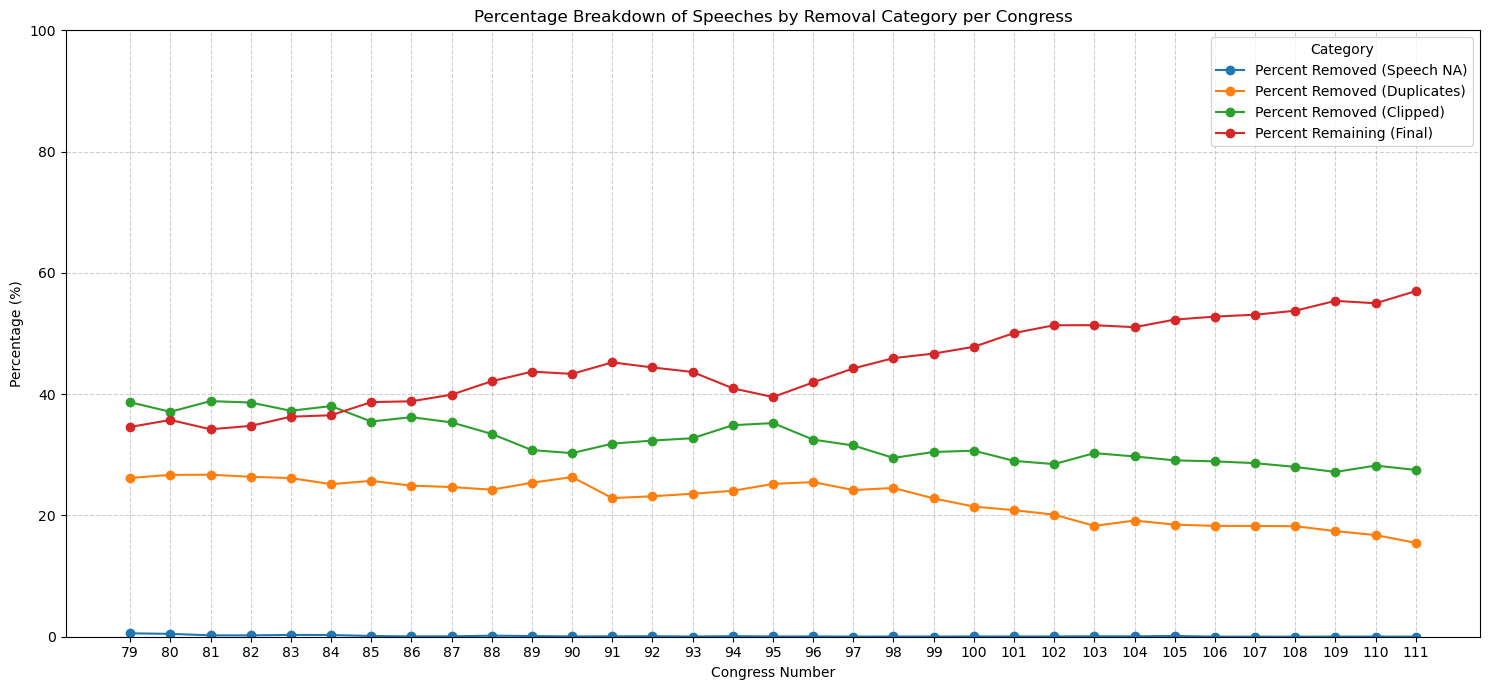

In [7]:
#loading stats
with open ("clipping_stats.json", "r") as f:
    clipping_stats_list = json.load(f)
    
clipping_stats_df = pd.DataFrame(clipping_stats_list)

# Optional: Sort the DataFrame by Congress number for a cleaner plot (Same as before)
clipping_stats_df = clipping_stats_df.sort_values('Congress').reset_index(drop=True)

# Print the final statistics table (optional)
print("\n--- Clipping Statistics Summary ---")
print(clipping_stats_df)

# 2. Calculate Percentage Statistics (UPDATED)
# Calculate percentages relative to the 'Start Count (After Basic Clean)'
# Handle potential division by zero by replacing 0 in the base count with NaN before division
base_count = clipping_stats_df['Start Count (After Basic Clean)'].replace(0, np.nan)

clipping_stats_df['Percent Removed (Speech NA)'] = (clipping_stats_df['Removed (Speech NA)'] / base_count) * 100
clipping_stats_df['Percent Removed (Duplicates)'] = (clipping_stats_df['Removed (Duplicates)'] / base_count) * 100
clipping_stats_df['Percent Removed (Clipped)'] = (clipping_stats_df['Removed (Clipped)'] / base_count) * 100
clipping_stats_df['Percent Remaining (Final)'] = (clipping_stats_df['Final Count (After Clipping)'] / base_count) * 100


# Replace any inf or NaN values (resulting from division by zero or NaN base_count) with 0
pct_cols_to_fill = ['Percent Removed (Speech NA)', 'Percent Removed (Duplicates)', 'Percent Removed (Clipped)', 'Percent Remaining (Final)']
clipping_stats_df[pct_cols_to_fill] = clipping_stats_df[pct_cols_to_fill].replace([np.inf, -np.inf], np.nan).fillna(0)


# --- 3. Visualize Raw Counts using a STACKED Bar Plot (UPDATED) ---
print("\nGenerating Stacked Bar Plot (Raw Counts)...")
plt.figure(figsize=(20, 8)) # Create a new figure for the bar plot

# Set Congress as the index for plotting
clipping_stats_df_indexed_bar = clipping_stats_df.set_index('Congress')

# Select the columns you want to plot as stacked bars.
# Order matters for the stack layers. Placing 'Final Count' at the bottom is common.
columns_to_stack = [
    'Final Count (After Clipping)',
    'Removed (Clipped)',         # Clipped on top of Final
    'Removed (Duplicates)',      # Duplicates on top of Clipped
    'Removed (Speech NA)'        # Speech NA on top of Duplicates
]

ax_bar = clipping_stats_df_indexed_bar[columns_to_stack].plot(
    kind='bar',
    stacked=True, # This makes it a stacked bar plot
    ax=plt.gca() # Use the current axes created by plt.figure()
)

# Add titles and labels
plt.title('Breakdown of Speeches by Removal Category and Final Count per Congress')
plt.xlabel('Congress Number')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.legend(title='Category')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid

# Improve layout
plt.tight_layout()

# Show the bar plot
plt.show()


# --- 4. Visualize Percentage Statistics using a Line Plot (UPDATED) ---
print("Generating Line Plot (Percentages)...")
plt.figure(figsize=(15, 7)) # Create a new figure for the line plot

# Use the 'Congress' column directly for the x-axis
# Select the new percentage columns to plot
percentage_columns_to_plot = [
    'Percent Removed (Speech NA)',
    'Percent Removed (Duplicates)',
    'Percent Removed (Clipped)',
    'Percent Remaining (Final)'
]

ax_line = clipping_stats_df.plot(
    x='Congress',
    y=percentage_columns_to_plot,
    kind='line',
    marker='o', # Add markers
    ax=plt.gca() # Use the current axes created by plt.figure()
)

# Add titles and labels
plt.title('Percentage Breakdown of Speeches by Removal Category per Congress')
plt.xlabel('Congress Number')
plt.ylabel('Percentage (%)')
plt.xticks(clipping_stats_df['Congress']) # Ensure all Congress numbers are shown
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid
plt.legend(title='Category')

# Set y-axis limits from 0 to 100
plt.ylim(0, 100)

# Improve layout
plt.tight_layout()

# Show the line plot
plt.show()


# Optional: Save the statistics DataFrame to a CSV file
# stats_output_path = Path("../data/processing_stats/clipping_summary.csv")
# stats_output_path.parent.mkdir(parents=True, exist_ok=True)
# # Save the version *with* percentages now
# clipping_stats_df.to_csv(stats_output_path, index=False)
# print(f"\nClipping statistics saved to {stats_output_path}")

# --- END SNIPPET ---

# Fetching stats

### House of Representative stats

In [32]:
house_result_frames = []
house_speech_length_stats = []

for i in range(79, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"
    df = pd.read_csv(house_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    house_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))     
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = house_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    house_party_year_stats['pct_speeches'] = (
        house_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    house_party_year_stats['pct_speakers'] = (
        house_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    house_party_year_stats = house_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = house_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        house_party_year_stats = house_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")

    house_result_frames.append(house_party_year_stats.reset_index())
    
    stats = df["word_count"].describe().to_frame().T
    stats["Congress number"] = i
    house_speech_length_stats.append(stats)
    
    #print(house_party_year_stats.round(1))
    
house_speech_stats_df = pd.concat(house_speech_length_stats, ignore_index=True)
house_speech_length_df = house_speech_stats_df.round({
    'mean': 2,
    'std': 2
})

── Processing Congress 79 ──
── Processing Congress 80 ──
── Processing Congress 81 ──
removed tiny-overlap year(s): [1951]
── Processing Congress 82 ──
── Processing Congress 83 ──
── Processing Congress 84 ──
── Processing Congress 85 ──
── Processing Congress 86 ──
── Processing Congress 87 ──
── Processing Congress 88 ──
── Processing Congress 89 ──
── Processing Congress 90 ──
── Processing Congress 91 ──
removed tiny-overlap year(s): [1971]
── Processing Congress 92 ──
── Processing Congress 93 ──
── Processing Congress 94 ──
── Processing Congress 95 ──
── Processing Congress 96 ──
── Processing Congress 97 ──
── Processing Congress 98 ──
── Processing Congress 99 ──
── Processing Congress 100 ──
── Processing Congress 101 ──
── Processing Congress 102 ──
── Processing Congress 103 ──
── Processing Congress 104 ──
── Processing Congress 105 ──
── Processing Congress 106 ──
── Processing Congress 107 ──
── Processing Congress 108 ──
── Processing Congress 109 ──
── Processing Con

In [33]:
print(house_speech_length_df.head())

     count    mean     std   min   25%    50%    75%      max  Congress number
0  33622.0  266.04  442.59  41.0  62.0  112.0  277.0  12783.0               79
1  25281.0  280.54  443.95  41.0  64.0  127.0  312.0  11089.0               80
2  33025.0  271.27  432.95  41.0  62.0  114.0  294.0   6691.0               81
3  29677.0  268.06  430.13  41.0  63.0  115.0  290.0  11478.0               82
4  27546.0  288.27  454.65  41.0  64.0  122.0  322.0  15092.0               83


### Senate stats

In [1]:
senate_result_frames = []
senate_speech_length_stats = []

for i in range(79, 112):
    
    "------ Loading files -------"
    
    print(f'── Processing Congress {i} ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    senate_file = base_dir / f"senate_db/senate_merged_{year_str}.csv"
    
    print("Processing:", senate_file)
    df = pd.read_csv(senate_file)
    
    "------ Grouping  -------"
    
    #grouping by party and counting speaker and speech
    senate_party_year_stats = (
        df.groupby(['year', 'party'])
        .agg(num_speeches=('speech_id',  'count'),
            num_speakers=('speakerid',  'nunique'),
            mean_words   =('word_count','mean'))      
        .rename(index={'R':'Republican', 'D':'Democrat'})
        .sort_index()
    )
    
    #adding proportion to the table
    
    #Find the per‑year denominator for each metric
    year_totals = senate_party_year_stats.groupby(level='year').transform('sum')
    #Add percentage columns (×100 for a friendlier reading)
    senate_party_year_stats['pct_speeches'] = (
        senate_party_year_stats['num_speeches'] / year_totals['num_speeches'] * 100
    )
    senate_party_year_stats['pct_speakers'] = (
        senate_party_year_stats['num_speakers'] / year_totals['num_speakers'] * 100
    )
    #Order of columns
    senate_party_year_stats = senate_party_year_stats[
        ['num_speeches', 'pct_speeches', 'num_speakers', 'pct_speakers', "mean_words"]
    ]
    
    #dropping the third year. < 1000 speech trash
    yr_totals = senate_party_year_stats.groupby(level='year')['num_speeches'].sum()
    years_to_drop = yr_totals[yr_totals < 1000].index   # Index of bad years
    if len(years_to_drop):
        senate_party_year_stats = senate_party_year_stats.drop(years_to_drop, level='year')
        print(f"removed tiny-overlap year(s): {list(years_to_drop)}")

    
    senate_result_frames.append(senate_party_year_stats.reset_index())
    stats = df["word_count"].describe().to_frame().T
    stats["Congress number"] = i
    senate_speech_length_stats.append(stats)

senate_speech_stats_df = pd.concat(senate_speech_length_stats, ignore_index=True)
senate_speech_length_df = senate_speech_stats_df.round({
    'mean': 2,
    'std': 2
})

    #print(senate_party_year_stats.round(1))

── Processing Congress 79 ──


NameError: name 'Path' is not defined

In [35]:


# Display the resulting DataFrame
print(house_speech_length_df)
print(senate_speech_length_df)

      count    mean     std   min    25%    50%     75%      max  \
0   33622.0  266.04  442.59  41.0   62.0  112.0  277.00  12783.0   
1   25281.0  280.54  443.95  41.0   64.0  127.0  312.00  11089.0   
2   33025.0  271.27  432.95  41.0   62.0  114.0  294.00   6691.0   
3   29677.0  268.06  430.13  41.0   63.0  115.0  290.00  11478.0   
4   27546.0  288.27  454.65  41.0   64.0  122.0  322.00  15092.0   
5   26949.0  297.06  470.57  41.0   63.0  121.0  326.00   8226.0   
6   33817.0  302.24  483.30  41.0   67.0  133.0  338.00  20934.0   
7   30265.0  315.03  479.26  41.0   68.0  140.0  358.00   9927.0   
8   34845.0  320.85  481.79  41.0   71.0  146.0  367.00  12531.0   
9   36660.0  335.46  483.19  41.0   76.0  167.0  397.00  16833.0   
10  49121.0  339.42  470.00  41.0   79.0  177.0  409.00  11282.0   
11  54693.0  326.04  438.58  41.0   84.0  184.0  395.00  11197.0   
12  49731.0  325.63  429.10  41.0   81.0  181.0  400.00  11211.0   
13  43523.0  333.78  433.37  41.0   82.0  187.0 

In [21]:
# Define the fixed word count threshold
LENGTH_THRESHOLD = 350

# Initialize a list to store stats for speeches over the threshold
house_speeches_over_threshold_stats = []

for i in range(79, 112):

    "------ Loading files -------"

    print(f'── Processing Congress {i} (Threshold >= {LENGTH_THRESHOLD} words) ──')
    year_str = f"{i:03}"
    base_dir = Path("../data/merged")
    house_file = base_dir / f"house_db/house_merged_{year_str}.csv"

    # Check if file exists before trying to read
    if not house_file.exists():
        print(f"Warning: File not found for Congress {i}: {house_file}")
        continue # Skip this iteration if file is missing

    try:
        df = pd.read_csv(house_file)
    except Exception as e:
        print(f"Error reading file for Congress {i}: {e}")
        continue # Skip this iteration on error


    "------ Filtering and Calculating Stats for Speeches over Threshold -------"

    word_counts = df["word_count"]

    # Filter the DataFrame to get only speeches with word_count >= LENGTH_THRESHOLD
    speeches_over_threshold_df = df[word_counts >= LENGTH_THRESHOLD].copy() # .copy() to avoid SettingWithCopyWarning

    # Check if there are any speeches that meet the threshold in this Congress
    if not speeches_over_threshold_df.empty:
        # Calculate descriptive statistics for this subset of speeches
        stats_over_threshold = speeches_over_threshold_df["word_count"].describe().to_frame().T

        # Add the Congress number
        stats_over_threshold["Congress number"] = i

        # Reorder columns to put 'Congress number' first
        cols_over_threshold = stats_over_threshold.columns.tolist()
        new_order_over_threshold = ['Congress number'] + [col for col in cols_over_threshold if col != 'Congress number']
        stats_over_threshold = stats_over_threshold[new_order_over_threshold]

        # Append to the list
        house_speeches_over_threshold_stats.append(stats_over_threshold)
    else:
        # Handle cases where no speeches meet the threshold for a given Congress
        print(f"No speeches found >= {LENGTH_THRESHOLD} words for Congress {i}")
        # You might want to append a row of zeros/NaNs here if you need a complete table
        # For now, we'll just skip appending for this Congress


    # --- Your original loop code for overall stats or party stats can remain here if needed ---
    # "------ Grouping  -------"
    # ... (your grouping code) ...
    # house_result_frames.append(house_party_year_stats.reset_index())
    # ----------------------------------------------------------------------------------------


# After the loop, concatenate the list of stats DataFrames for speeches over the threshold
if house_speeches_over_threshold_stats:
    house_speeches_over_threshold_df = pd.concat(house_speeches_over_threshold_stats, ignore_index=True)

    # Optional: Round columns for cleaner display
    house_speeches_over_threshold_df_rounded = house_speeches_over_threshold_df.round({
        'count': 0,      # Count should be integer
        'mean': 2,
        'std': 2,
        'min': 0,
        '25%': 0,
        '50%': 0,
        '75%': 0,
        'max': 0
    })


    # Display the resulting DataFrame
    print(f"\n--- Speech Length Stats (Speeches >= {LENGTH_THRESHOLD} words) ---")
    print(house_speeches_over_threshold_df_rounded)
else:
    print(f"\nNo speeches found >= {LENGTH_THRESHOLD} words across the specified Congresses.")

── Processing Congress 79 (Threshold >= 350 words) ──
── Processing Congress 80 (Threshold >= 350 words) ──
── Processing Congress 81 (Threshold >= 350 words) ──
── Processing Congress 82 (Threshold >= 350 words) ──
── Processing Congress 83 (Threshold >= 350 words) ──
── Processing Congress 84 (Threshold >= 350 words) ──
── Processing Congress 85 (Threshold >= 350 words) ──
── Processing Congress 86 (Threshold >= 350 words) ──
── Processing Congress 87 (Threshold >= 350 words) ──
── Processing Congress 88 (Threshold >= 350 words) ──
── Processing Congress 89 (Threshold >= 350 words) ──
── Processing Congress 90 (Threshold >= 350 words) ──
── Processing Congress 91 (Threshold >= 350 words) ──
── Processing Congress 92 (Threshold >= 350 words) ──
── Processing Congress 93 (Threshold >= 350 words) ──
── Processing Congress 94 (Threshold >= 350 words) ──
── Processing Congress 95 (Threshold >= 350 words) ──
── Processing Congress 96 (Threshold >= 350 words) ──
── Processing Congress 97 (T

# Graph stats

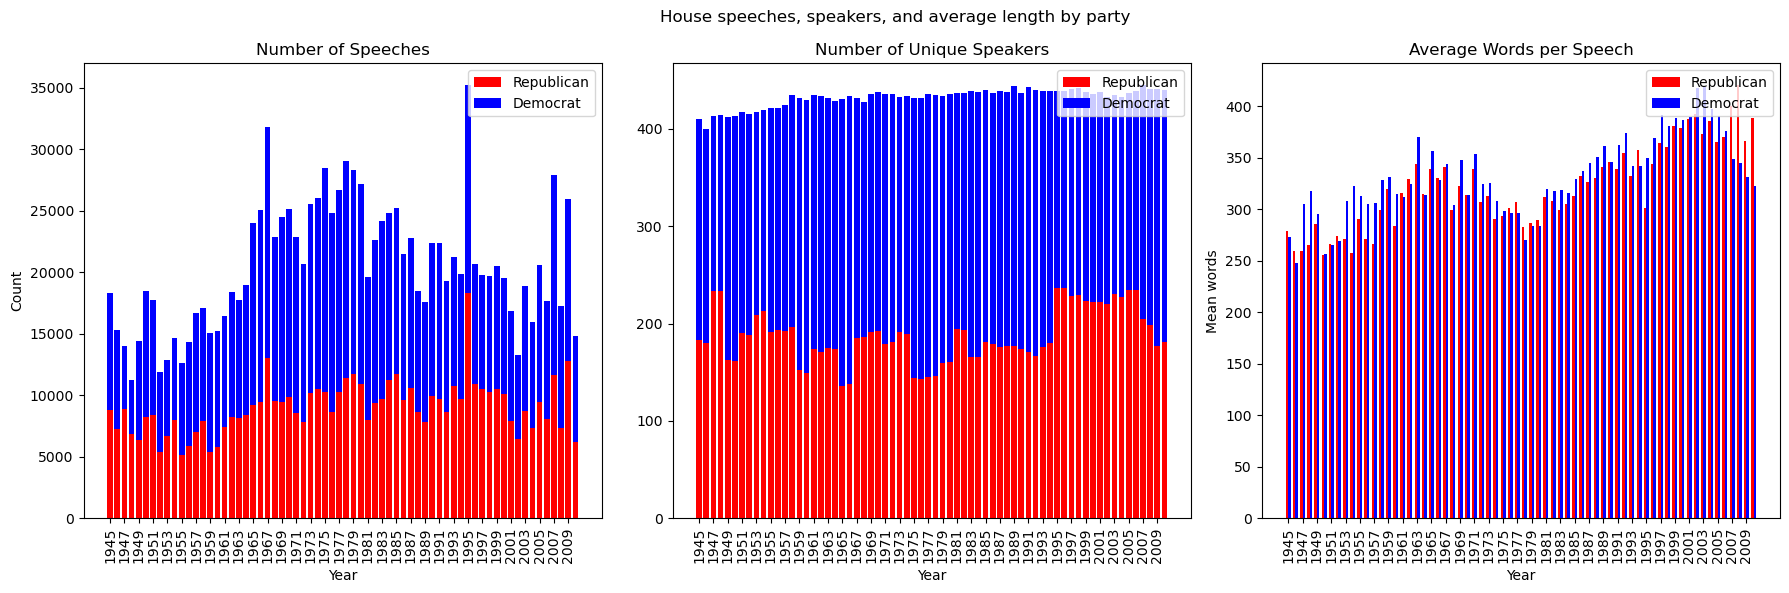

In [36]:
# ---------- collect the tables built in Cell 1 ----------
all_stats = pd.concat(house_result_frames, ignore_index=True)


agg = (
    all_stats
    .groupby(['year', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
        num_speakers=('num_speakers', 'sum'),
        mean_words  =('mean_words',  'mean'))
)

# wide tables
speech_pct   = all_stats.pivot(index='year', columns='party', values='pct_speeches').fillna(0)
speaker_pct  = all_stats.pivot(index='year', columns='party', values='pct_speakers').fillna(0)
speech_vals  = agg.pivot(index='year', columns='party', values='num_speeches').fillna(0)
speaker_vals = agg.pivot(index='year', columns='party', values='num_speakers').fillna(0)
mean_words   = agg.pivot(index='year', columns='party', values='mean_words').fillna(0)


# make sure both parties are present
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

years = speech_vals.index.astype(str)
x     = np.arange(len(years))          # numeric x‑positions

# assume speech_vals, speaker_vals, mean_words are already built
years = speech_vals.index.astype(str)
x     = np.arange(len(years))

rs, ds = speech_vals['Republican'],  speech_vals['Democrat']
ru, du = speaker_vals['Republican'], speaker_vals['Democrat']
rw, dw = mean_words['Republican'],   mean_words['Democrat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# A ‒ speeches
axes[0].bar(x, rs, color='red',  label='Republican')
axes[0].bar(x, ds, bottom=rs, color='blue', label='Democrat')
axes[0].set_title('Number of Speeches')
axes[0].set_ylabel('Count')

# B ‒ speakers
axes[1].bar(x, ru, color='red',  label='Republican')
axes[1].bar(x, du, bottom=ru, color='blue', label='Democrat')
axes[1].set_title('Number of Unique Speakers')

# C ‒ mean words (side‑by‑side)
bar_w = 0.35
axes[2].bar(x - bar_w/2, rw, width=bar_w, color='red',  label='Republican')
axes[2].bar(x + bar_w/2, dw, width=bar_w, color='blue', label='Democrat')
axes[2].set_title('Average Words per Speech')
axes[2].set_ylabel('Mean words')

# -------------- show only every 2nd year -----------------------------
tick_pos   = x[::2]      # 0, 2, 4, …
tick_labels = years[::2]

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Year')
    ax.legend(loc='upper right')

fig.suptitle('House speeches, speakers, and average length by party')
plt.tight_layout()
plt.show()


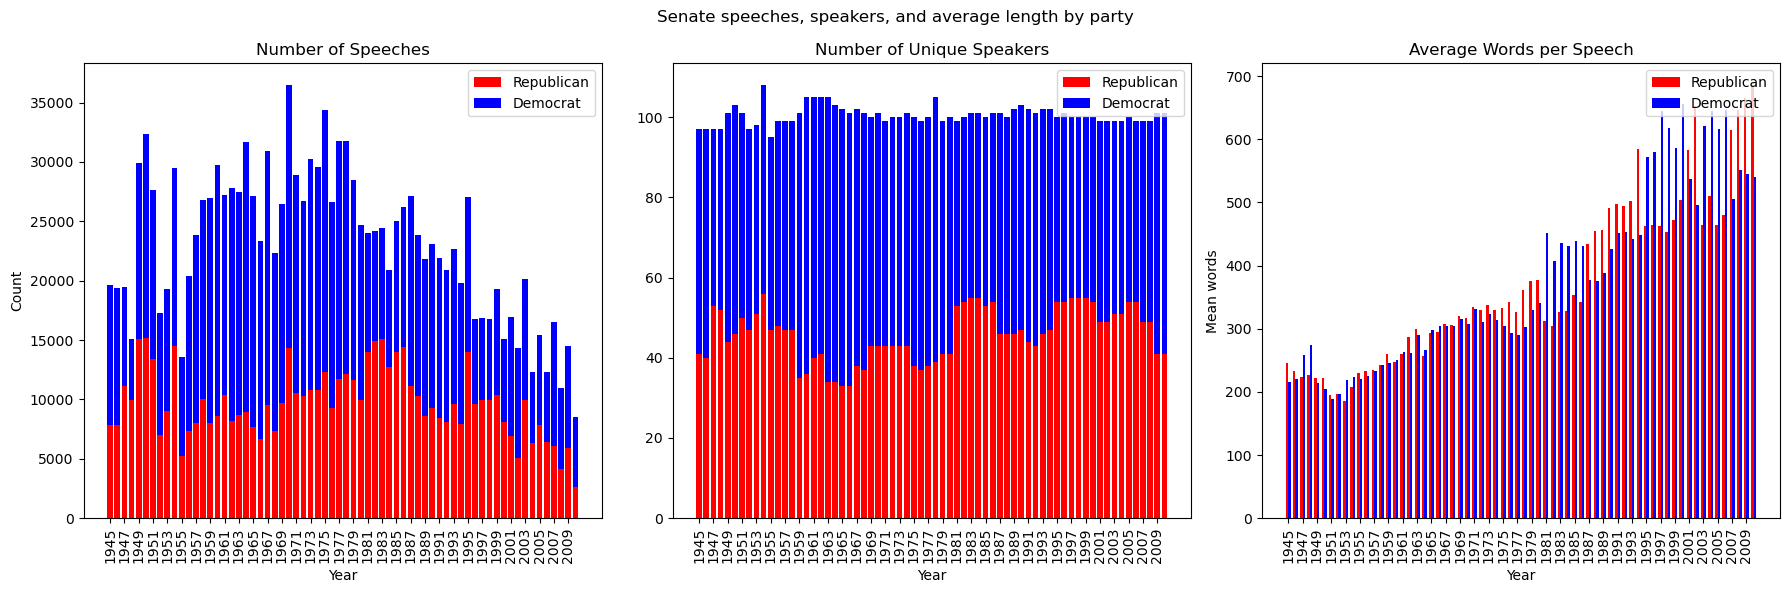

In [37]:
# ---------- collect the tables built in Cell 1 ----------
all_stats = pd.concat(senate_result_frames, ignore_index=True)


agg = (
    all_stats
    .groupby(['year', 'party'], as_index=False)
    .agg(num_speeches=('num_speeches', 'sum'),
        num_speakers=('num_speakers', 'sum'),
        mean_words  =('mean_words',  'mean'))
)

# wide tables
speech_pct   = all_stats.pivot(index='year', columns='party', values='pct_speeches').fillna(0)
speaker_pct  = all_stats.pivot(index='year', columns='party', values='pct_speakers').fillna(0)
speech_vals  = agg.pivot(index='year', columns='party', values='num_speeches').fillna(0)
speaker_vals = agg.pivot(index='year', columns='party', values='num_speakers').fillna(0)
mean_words   = agg.pivot(index='year', columns='party', values='mean_words').fillna(0)


# make sure both parties are present
for p in ['Republican', 'Democrat']:
    for tbl in [speech_vals, speaker_vals, speech_pct, speaker_pct, mean_words]:
        if p not in tbl.columns:
            tbl[p] = 0

years = speech_vals.index.astype(str)
x     = np.arange(len(years))          # numeric x‑positions

# assume speech_vals, speaker_vals, mean_words are already built
years = speech_vals.index.astype(str)
x     = np.arange(len(years))

rs, ds = speech_vals['Republican'],  speech_vals['Democrat']
ru, du = speaker_vals['Republican'], speaker_vals['Democrat']
rw, dw = mean_words['Republican'],   mean_words['Democrat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# A ‒ speeches
axes[0].bar(x, rs, color='red',  label='Republican')
axes[0].bar(x, ds, bottom=rs, color='blue', label='Democrat')
axes[0].set_title('Number of Speeches')
axes[0].set_ylabel('Count')

# B ‒ speakers
axes[1].bar(x, ru, color='red',  label='Republican')
axes[1].bar(x, du, bottom=ru, color='blue', label='Democrat')
axes[1].set_title('Number of Unique Speakers')

# C ‒ mean words (side‑by‑side)
bar_w = 0.35
axes[2].bar(x - bar_w/2, rw, width=bar_w, color='red',  label='Republican')
axes[2].bar(x + bar_w/2, dw, width=bar_w, color='blue', label='Democrat')
axes[2].set_title('Average Words per Speech')
axes[2].set_ylabel('Mean words')

# -------------- show only every 2nd year -----------------------------
tick_pos   = x[::2]      # 0, 2, 4, …
tick_labels = years[::2]

for ax in axes:
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_xlabel('Year')
    ax.legend(loc='upper right')

fig.suptitle('Senate speeches, speakers, and average length by party')
plt.tight_layout()
plt.show()
